4.1.2
1.14.0
(?, 3, 3, 64)


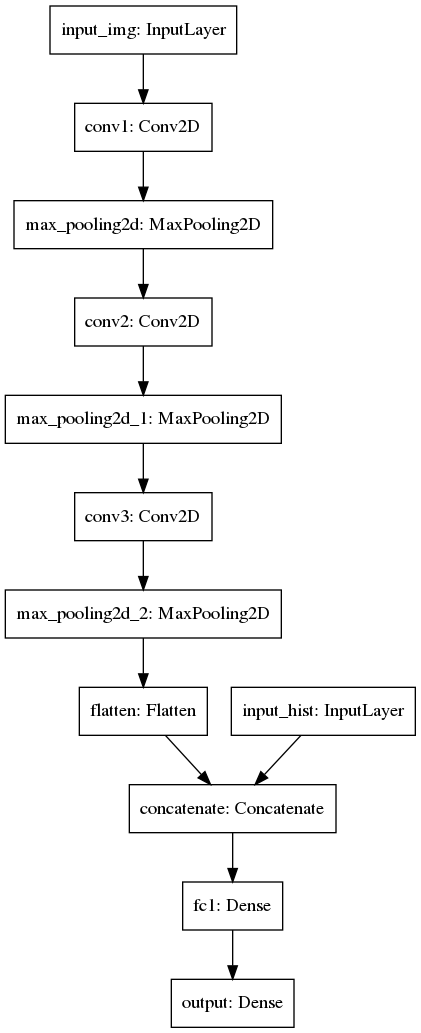

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow import keras


tf.keras.backend.clear_session()  # For easy reset of notebook state.
print(cv2.__version__)
print(tf.__version__)
#assert tf.executing_eagerly() == True

class_names = ["black", "blue", "brown", "gold", "green", "orange", "purple", "red", "silver", "white"]
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHN = 3
RGB_MEAN = [0.485, 0.456, 0.406]
RGB_STD = [0.229, 0.224, 0.225]

def generate_generator(generator, path, batch_size = 16, img_height = IMG_HEIGHT, img_width = IMG_WIDTH):

        gen = generator.flow_from_directory(path,
                                            classes = class_names,
                                            target_size = (img_height,img_width),
                                            batch_size = batch_size,
                                            shuffle=True, 
                                            seed=7)
        while True:
            X,y = gen.next()    
            data = []
            for img in X:
                chans = cv2.split(img.astype(np.uint8))
                colors = ("r", "b", "g")
                features = []
                # loop over the image channels
                for (chan, color) in zip(chans, colors):
                    hist = cv2.calcHist([chan], [0], None, [128], [0.0, 255.0])
                    features.extend(hist)
                features = np.squeeze(np.array(features))
                data.append(features)
            data = np.array(data)/255.0
            yield [X,data], y #Yield both images and their mutual label
                
class Dataloader:
    def __init__(self, data_path,  batch_size = 16):
        
       	train_imgen = keras.preprocessing.image.ImageDataGenerator(rotation_range = 10,\
										width_shift_range = 0.35, height_shift_range = 0.35,\
										horizontal_flip = True, rescale = 1/255.0)

        test_imgen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

        self.train_generator = generate_generator(train_imgen,
                                               path = str(data_path) + "train/",
                                               batch_size=batch_size)       

        self.val_generator = generate_generator(test_imgen,
                                              path = str(data_path)+ "val/",
                                              batch_size=batch_size)              

        
    def load_image(self, val = False):
        if val:
            return next(self.val_generator)
        else:
            return next(self.train_generator)
    
    def load_dl(self):
        return [self.train_generator, self.val_generator]


def CarColorClassificationNet(): 
    
    
    input_img = layers.Input(shape = (256,256,3), dtype = 'float32', name = "input_img" )
    x = layers.Conv2D(16, 3, strides=(2, 2), name = "conv1",\
                                padding='valid', activation="relu", kernel_initializer='glorot_uniform')(input_img)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, strides=(2, 2), name = "conv2",\
                                padding='valid', activation="relu", kernel_initializer='glorot_uniform')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, strides=(2, 2), name = "conv3",\
                                padding='valid', activation="relu", kernel_initializer='glorot_uniform')(x)
    x = layers.MaxPool2D()(x)
    print(x.shape)
    img_feat = layers.Flatten()(x)
    input_hist = layers.Input(shape = (128*3), dtype = 'float32', name = "input_hist" )
    fc_input = layers.Concatenate()([input_hist, img_feat])
    x = layers.Dense(64, activation= 'relu', name = "fc1", kernel_initializer = 'glorot_uniform')(fc_input)
    output = layers.Dense(10, activation= 'softmax', name = "output", kernel_initializer = 'glorot_uniform')(x)
    

    model = keras.Model(inputs=[input_img, input_hist], outputs=output)
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return model

#create DNN model

lr = 8.5e-4
batch_size = 16
trainset_size = 3129
valset_size = 575
epochs = 500
dl = Dataloader("./mixed_vehicle_dataset/")
train_generator, val_generator = dl.load_dl()
checkpoint_path = "./weights_hyb_02/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


model = CarColorClassificationNet()
#model.load_weights("./training_simple_finetuned_83/cp.ckpt")
keras.utils.plot_model(model, 'vehicle_color_classification.png')




In [ ]:
model.fit_generator(train_generator,
                                steps_per_epoch=trainset_size/batch_size,
                                epochs = epochs,
                                validation_data = val_generator,
                                validation_steps = valset_size/batch_size,
                                use_multiprocessing = True,
                                shuffle=True,
                                callbacks=[cp_callback])

Found 3129 images belonging to 10 classes.
Epoch 1/500
195/195 [============================>.] - ETA: 0s - loss: 3.7588 - categorical_accuracy: 0.2446   

In [5]:
 class Dataloader:
    def __init__(self, data_path,  batch_size = 16):
        
        test_imgen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)
        self.test_generator = generate_generator(test_imgen,
                                              path = str(data_path)+ "test/",
                                              batch_size=batch_size)            
    def load_dl(self):
        return self.test_generator
    
batch_size = 16
checkpoint_path = "/checkpoints/" + "weights_hyb02/cp.ckpt"
testset_size = 188
epochs = 500
dl = Dataloader("./mixed_vehicle_dataset/")
test_generator = dl.load_dl()
#checkpoint_path = "training_simple_new_new/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                 verbose=1)


model = CarColorClassificationNet()
model.load_weights(checkpoint_path)
#model = tf.keras.experimental.load_from_saved_model("./models/")
#model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr),
#              loss=tf.keras.losses.CategoricalCrossentropy(),
#              metrics=[tf.keras.metrics.CategoricalAccuracy()])

loss, acc = model.evaluate_generator(test_generator,steps = testset_size/batch_size,use_multiprocessing = True)
print("Restored model, loss: {}, accuracy: {:5.2f}%".format(loss, acc*100))

(?, 3, 3, 64)
Found 188 images belonging to 10 classes.
Restored model, loss: 0.8866941326476158, accuracy: 82.45%


In [6]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [7]:
from keras import backend as K

# Create, compile and train model...

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 55 variables.
INFO:tensorflow:Converted 55 variables to const ops.


Using TensorFlow backend.


In [10]:
print([out.op.name for out in model.outputs])
print([out.op.name for out in model.inputs])

['output_2/Softmax']
['input_img_2', 'input_hist_2']


In [9]:
tf.train.write_graph(frozen_graph, "./", "hyb01.pb", as_text=False)
[n.name for n in tf.get_default_graph().as_graph_def().node]

print("model output to pb successful.")

['keras_learning_phase/input',
 'keras_learning_phase',
 'input_img',
 'conv1/kernel/Initializer/random_uniform/shape',
 'conv1/kernel/Initializer/random_uniform/min',
 'conv1/kernel/Initializer/random_uniform/max',
 'conv1/kernel/Initializer/random_uniform/RandomUniform',
 'conv1/kernel/Initializer/random_uniform/sub',
 'conv1/kernel/Initializer/random_uniform/mul',
 'conv1/kernel/Initializer/random_uniform',
 'conv1/kernel',
 'conv1/kernel/IsInitialized/VarIsInitializedOp',
 'conv1/kernel/Assign',
 'conv1/kernel/Read/ReadVariableOp',
 'conv1/bias/Initializer/zeros',
 'conv1/bias',
 'conv1/bias/IsInitialized/VarIsInitializedOp',
 'conv1/bias/Assign',
 'conv1/bias/Read/ReadVariableOp',
 'conv1/dilation_rate',
 'conv1/Conv2D/ReadVariableOp',
 'conv1/Conv2D',
 'conv1/BiasAdd/ReadVariableOp',
 'conv1/BiasAdd',
 'conv1/Relu',
 'max_pooling2d/MaxPool',
 'conv2/kernel/Initializer/random_uniform/shape',
 'conv2/kernel/Initializer/random_uniform/min',
 'conv2/kernel/Initializer/random_uniform/